# Bias base line

In [560]:
library(sdazar)
library(readxl)
library(lubridate)
library(ggplot2)
library(patchwork)
library(ggrepel)
library(ggridges)
source('utils/functions.R')

## Read administrative data (non-respondents)

In [561]:
nores = data.table(read_excel('data/Datos de mujeres - Estudio Sociologia UC.xlsx', sheet=2))

In [562]:
setnames(nores, names(nores), tolower(names(nores)))

In [563]:
nores[, id := .I]

In [564]:
vars = c('id', 'fecha ingreso', 'fecha egreso', 'delito', 'extensión de condena', 
         'patio', 'unidad', 'n de condenas anteriores', 'año de nacimiento', 'edad al ingreso', 
         'comuna', 'estado civil', 'hijos (cantidad)')

In [565]:
nores = nores[, vars, with=FALSE]

In [566]:
nvars = c('id', 'ingreso', 'fegreso', 'delito', 'condena', 
         'patio', 'unidad', 'ncondenas', 'nacimiento', 'edad_ingreso', 
         'comuna', 'estado_civil', 'nhijos')

In [567]:
setnames(nores, vars, nvars)

So the variables I would use are: 

- crime 
- unit
- number of sentences
- year born
- number of kids
- married

In [568]:
# head(nores)

### Read Baseline

In [569]:
# read base line data
b = fread('data/170630 Base Reinserción Línea Base.csv')
setnames(b, names(b), tolower(names(b)))

vars = c('muestra', 'folio_2', 'p3_anio', 'p1', 'p5', 'p131', 'p13', 'p137')
nvars = c('muestra', 'id', 'nacimiento', 'edad', 'unidad', 'condena_anterior', 'nhijos', 'delito')
setnames(b, vars, nvars)

In [570]:
b = b[muestra==1]

### married

In [571]:
b = assmis(b, list(c('p79', 'p60')), list(9))
b[, casada := pmax(p60, p79, na.rm=TRUE)][is.na(casada) & p49==0, casada:=0][is.na(casada), casada := 0]
prop.table(table(b$casada, useNA='ifany')) # lower proportion


   0    1 
0.92 0.08 

In [572]:
nores[, casada := ifelse(estado_civil=='Casada', 1, 0)]
prop.table(table(nores$casada, useNA='ifany'))


        0         1 
0.8867925 0.1132075 

### kids

In [573]:
table(b$nhijos, useNA='ifany')


 0  1  2  3  4  5  6  7  8  9 11 
24 51 47 45 27 10 13  5  1  1  1 

In [574]:
table(nores$nhijos, useNA='ifany')


 0  1  2  3  4  5  6  7  8 10 11 
 4 14  8  9  7  4  2  2  1  1  1 

### sentence before

In [575]:
nores[, condena_anterior := as.numeric(ncondenas>0)]
prop.table(table(nores$condena_anterior))


        0         1 
0.2830189 0.7169811 

In [576]:
b = assmis(b, list('condena_anterior'), list(9))
prop.table(table(b$condena_anterior))


        0         1 
0.2366071 0.7633929 

### year born

In [577]:
nores[, nac := as.numeric(nacimiento)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [578]:
nores[is.na(nac), nac := year(ingreso)- as.numeric(edad_ingreso)]

In [579]:
summary(nores$nac, useNA = 'ifany')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1938    1973    1981    1979    1991    1996 

In [580]:
b = assmis(b, list('nacimiento'), list(9999))

In [581]:
b[, nac := as.numeric(nacimiento)]

In [582]:
b[, ent_fecha := as.Date(fecha, "%m/%d/%Y")]

In [583]:
b[is.na(nac), nac := year(ent_fecha) - as.numeric(edad)]

In [584]:
summary(b$nac)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1948    1974    1982    1980    1989    1997 

### unit

In [585]:
table(nores$unidad)


       CPF TALITA KUM 
        50          3 

In [586]:
nores[, cpf := ifelse(unidad=='CPF', 1, 0)]

In [587]:
summary(nores$cpf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9434  1.0000  1.0000 

In [588]:
b = assmis(b, list('unidad'), list(9))

In [589]:
b[, cpf := ifelse(unidad==1, 1, 0)]

In [590]:
summary(b$cpf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  1.0000  1.0000  0.9685  1.0000  1.0000       3 

### crime

In [591]:
table(nores$delito)


        Asociación ilícita                    Estafas 
                         1                          1 
                 Homicidio                      Hurto 
                         1                          3 
              Hurto simple      Infracción Ley 17.336 
                        21                          1 
Lesiones graves gravísimas                 Ley 20.000 
                         1                         15 
              Microtráfico                Receptación 
                         1                          1 
        Robo con violencia  Robo en lugar no habitado 
                         1                          1 
         Robo por sorpresa      Sustracciones menores 
                         1                          1 
                   Tráfico 
                         3 

In [592]:
labels = sort(unique(nores$delito))

##### groups
1. Hurto
2. Otros delitos contra la propiedad
3. Delitos de drogas
4. Delitos contra las personas
5. Otro

In [593]:
codes = c(5,2,4,1,1,2,4,3,3,2,2,2,2,4,3)

In [594]:
nores[.(delito=labels, to=codes), on='delito', rdelito := i.to]

In [595]:
table( nores$delito,nores$rdelito, useNA = 'ifany')

                            
                              1  2  3  4  5
  Asociación ilícita          0  0  0  0  1
  Estafas                     0  1  0  0  0
  Homicidio                   0  0  0  1  0
  Hurto                       3  0  0  0  0
  Hurto simple               21  0  0  0  0
  Infracción Ley 17.336       0  1  0  0  0
  Lesiones graves gravísimas  0  0  0  1  0
  Ley 20.000                  0  0 15  0  0
  Microtráfico                0  0  1  0  0
  Receptación                 0  1  0  0  0
  Robo con violencia          0  1  0  0  0
  Robo en lugar no habitado   0  1  0  0  0
  Robo por sorpresa           0  1  0  0  0
  Sustracciones menores       0  0  0  1  0
  Tráfico                     0  0  3  0  0

In [596]:
table(b$delito, useNA = 'ifany')


 1  2  3  5  7  8  9 10 11 12 13 15 16 17 18 19 22 24 99 
 3  4  5  1 85  1  9 11 11  1  4 37 44  1  3  1  1  2  1 

In [553]:
lookvar(b, 'p137')

[1] "p137_otro"

In [597]:
b[p137_otro %in% c('LEY EMILIA'), delito :=13]
b[p137_otro %in% c('PARRICIDIO'), delito :=24]

In [599]:
codes = c(2,2,2,2,1,2,2,2,2,4,4,3,3,2,2,4,2,5,99)
dcodes = sort(unique(b$delito))

In [600]:
length(codes) == length(dcodes)

[1] TRUE

In [602]:
b[.(delito=dcodes, to=codes), on='delito', rdelito:=i.to]

In [603]:
table(b$delito, b$rdelito)

    
      1  2  3  4  5 99
  1   0  3  0  0  0  0
  2   0  4  0  0  0  0
  3   0  5  0  0  0  0
  5   0  1  0  0  0  0
  7  85  0  0  0  0  0
  8   0  1  0  0  0  0
  9   0  9  0  0  0  0
  10  0 11  0  0  0  0
  11  0 11  0  0  0  0
  12  0  0  0  1  0  0
  13  0  0  0  5  0  0
  15  0  0 37  0  0  0
  16  0  0 44  0  0  0
  17  0  1  0  0  0  0
  18  0  3  0  0  0  0
  19  0  0  0  1  0  0
  22  0  1  0  0  0  0
  24  0  0  0  0  1  0
  99  0  0  0  0  0  1

In [604]:
b = assmis(b, list('rdelito'), list(99))
prop.table(table(b$rdelito))


          1           2           3           4           5 
0.379464286 0.223214286 0.361607143 0.031250000 0.004464286 

In [43]:
prop.table(table(nores$rdelito))


         1          2          3          4          5 
0.45283019 0.11320755 0.35849057 0.05660377 0.01886792 

# Differences between groups

In [605]:
# merge dataset

vars = c('id', 'cpf', 'nac', 'rdelito', 'casada', 'nhijos', 'condena_anterior')
b1 = b[, vars, with=FALSE][, sample := 1]
n1 = nores[, vars, with=FALSE][, sample := 0]

In [606]:
dat = rbind(b1, n1)

In [607]:
table(dat$sample)


  0   1 
 53 225 

In [608]:
head(dat)

id,cpf,nac,rdelito,casada,nhijos,condena_anterior,sample
20224,1,1997,1,0,0,1,1
30155,1,1968,3,0,0,1,1
10007,1,1994,3,0,0,0,1
40107,1,1990,2,0,0,1,1
20262,1,1975,1,0,0,1,1
20028,NA,1985,1,0,0,1,1


In [609]:
getdummies(dat, 'rdelito')

[[1]]
[1] "rdelito_1" "rdelito_3" "rdelito_2" "rdelito_4" "rdelito_5"



In [610]:
vars = paste0('rdelito_', 1:5)
nvars = c('del_hurto', 'del_propiedad', 'del_drogas', 'del_personas', 'del_otro')
setnames(dat, vars, nvars)

In [611]:
covars = c('cpf', 'nac', 'nhijos', 'condena_anterior', 'casada', nvars)
df = as.data.frame(dat[, covars, with=FALSE])
d = as.data.frame(rbm(df, as.factor(dat$sample)))

## Balance

In [612]:
d$labels = c('CPF', 'Año nacimiento', 'Num hijos', 'Condena anterior', 
             'Casada', 'Hurto', 'Delito propiedad', 'Delito drogas', 
            'Delito personas', 'Delito otro')

d$ind = as.numeric(abs(d$B) > .1)

In [613]:
plt = ggplot(d, aes(x=B, y=R, color=factor(ind))) + geom_point() +
    xlim(range(c(d$B[is.finite(d$B)], -1, 1))) +
    ylim(range(c(d$R[is.finite(d$R)], 0.1, 2))) + 
 geom_vline(xintercept = c(-0.1, 0.1), size=0.5, color='gray', linetype=3) + 
 geom_hline(yintercept = c(4/5, 5/4), size=0.5, color='gray', linetype=3) + 
 geom_text_repel(aes(B, R, label = labels), size=3) + 
 scale_color_manual(values=c('black', '#f03b20')) +
 labs(x='\nStandardized difference in means', y='Variance ratio\n') +  
 theme_classic() + theme(legend.position='none')

In [614]:
savepdf('plots/balance')
print(plt)
dev.off()

pdf 
  2

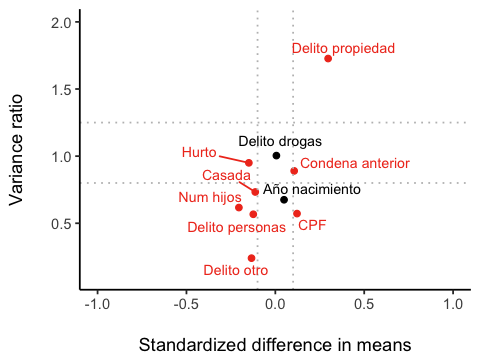

In [615]:
options(repr.plot.width = 4, repr.plot.height = 3)
plt

In [617]:
print(d)

                      B     R           labels ind
cpf               0.122 0.572              CPF   1
nac               0.049 0.675   Año nacimiento   0
nhijos           -0.205 0.617        Num hijos   1
condena_anterior  0.106 0.890 Condena anterior   1
casada           -0.113 0.733           Casada   1
del_hurto        -0.149 0.950            Hurto   1
del_propiedad     0.297 1.727 Delito propiedad   1
del_drogas        0.006 1.004    Delito drogas   0
del_personas     -0.124 0.567  Delito personas   1
del_otro         -0.134 0.240      Delito otro   1


# Standardized and relative bias

In [618]:
table(dat$sample)


  0   1 
 53 225 

In [619]:
# observed

ind = dat$sample

In [620]:
rs = dat[sample==1, covars, with=FALSE][, apply(.SD, 2, Mean)]
rp = dat[, covars, with=FALSE][, apply(.SD, 2, Mean)]

In [621]:
obs_r = (rs-rp)/rp

In [622]:
print(obs_r)

             cpf              nac           nhijos condena_anterior 
    5.014448e-03     5.844351e-05    -3.195309e-02     1.176948e-02 
          casada        del_hurto    del_propiedad       del_drogas 
   -7.333333e-02    -3.567333e-02     1.041135e-01     1.651786e-03 
    del_personas         del_otro 
   -1.343750e-01    -3.816964e-01 


In [623]:
srd = dat[, covars, with=FALSE][, lapply(.SD, scale)]
ind = dat$sample == 1
srs = srd[ind,apply(.SD, 2, Mean)]
srp = srd[,apply(.SD, 2, Mean)]

In [624]:
obs_s = (srs - srp)

In [625]:
print(obs_s)

             cpf              nac           nhijos condena_anterior 
     0.025766477      0.009975778     -0.041970414      0.020596368 
          casada        del_hurto    del_propiedad       del_drogas 
    -0.022501303     -0.028682493      0.052314209      0.001239315 
    del_personas         del_otro 
    -0.025958375     -0.032492371 


In [626]:
nrow(dat)

[1] 278

In [627]:
relbias = NULL
stdbias = NULL
for (i in 1:1000) { 
    ind = sample(nrow(dat), 225)
    
    rs = dat[ind, covars, with=FALSE][, apply(.SD, 2, Mean)]
    rp = dat[, covars, with=FALSE][, apply(.SD, 2, Mean)]
    
    srd = dat[, covars, with=FALSE][, lapply(.SD, scale)]
    srs = srd[ind,apply(.SD, 2, Mean)]
    srp = srd[,apply(.SD, 2, Mean)]
    
    s = (srs - srp)
    r = (rs-rp)/rp
    
    stdbias = rbind(stdbias, s)
    relbias = rbind(relbias, r)
    }

stdbias = as.data.table(stdbias)
relbias = as.data.table(relbias)

## Relative bias

In [628]:
covars = names(obs_r)

In [629]:
print(obs_r)

             cpf              nac           nhijos condena_anterior 
    5.014448e-03     5.844351e-05    -3.195309e-02     1.176948e-02 
          casada        del_hurto    del_propiedad       del_drogas 
   -7.333333e-02    -3.567333e-02     1.041135e-01     1.651786e-03 
    del_personas         del_otro 
   -1.343750e-01    -3.816964e-01 


In [630]:
labels =  c('CPF', 'Año nacimiento', 'Número hijos', 'Condena anterior', 
             'Casada', 'Hurto', 'Delito propiedad', 'Delito drogas', 
            'Delito personas', 'Delito otro')

In [631]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(relbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
          labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_r[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [632]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/relative_bias', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2

# standardized bias

In [633]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(stdbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
         labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_s[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [634]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/standardized_bias', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2